In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
%matplotlib inline

from sklearn import model_selection, datasets
np.random.seed()
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import cq as cq

import kq as kq
from qiskit import IBMQ
import numpy as np
import networkx as nx
from qiskit.providers.aer.noise import NoiseModel
from qiskit.tools.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit import execute, QuantumCircuit
from qiskit.tools.monitor import job_monitor
import pickle
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

# We will use a simple example to illustrate the procedure of using coreset and QAOA to perform 2-Means Clustering. That is to say, we will use coreset and QAOA to find 2 clusters. The result should be simular or a little bit higher than applying 2-Means Clustering directly on the whole dataset.

## First, let's have a look at the dataset. We use Iris dataset and select first 100 instances from it so that it has only 2 classes. Notice that the Iris dataset has 150 instances with 3 classes, we use only 2 classes becasue it is easier to viusalize.

### Let's load the dataset and plot it.

In [2]:
# Iris dataset is a binary dataset, it has two classes, 0 and 1, and each of them has 50 instances. 
iris = datasets.load_iris()
data_vectors = iris.data[0:100]
y = iris.target[0:100]
print('number of class 0 is: '+ str(y.tolist().count(0)) + ' (in blue below)')
print('number of class 1 is: '+ str(y.tolist().count(1)) + ' (in orange below)')

# Put data into a structure called 'dataframe' for further use.
iris_df = pd.DataFrame(iris['data'][0:100], columns=iris['feature_names'][0:100])
iris_df['label'] = iris['target'][0:100]
iris_df

number of class 0 is: 50 (in blue below)
number of class 1 is: 50 (in orange below)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
95,5.7,3.0,4.2,1.2,1
96,5.7,2.9,4.2,1.3,1
97,6.2,2.9,4.3,1.3,1
98,5.1,2.5,3.0,1.1,1


### We can see that the dataset we use has two classes and is in 4-D.

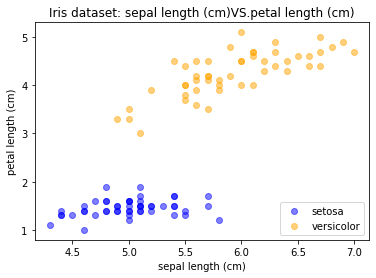

In [3]:
cq.plot_scatter(iris_df,D1='sepal length (cm)',D2 = 'petal length (cm)')

## Now we will construct the coreset. We have viewed that the two classes are very seperate and orangle cluster is sparser than blue cluster, which means if we use m = 3 coreset, two of coreset elements should be on the top right and one should be on the bottom left. 

### Step 1: Find number of k K-Means++ Clustering centerids (denoted as 'B'). Coreset is constructed based on these k centerids. We choose k = 5 at this time.

In [4]:
K = 5

In [5]:
# The K-Means++ Clustering centerids are selected from randomly selected points so the best centerids can not be guaranteed.
# Construct B multiple times to find the optimal value.
min_cost = np.inf
B_best = []
for _ in range(10):
    B = cq.D2Sampling(data_vectors, k=K)
    cost = 0
    for point in data_vectors:
        cost += cq.min_distance_to_B(point, B) ** 2
    if cost <= min_cost:
        B_best = B
        min_cost = cost

B = B_best
print('Value of KMeans++ Cluster centerids(B):')
B

Value of KMeans++ Cluster centerids(B):


[array([6.6, 2.9, 4.6, 1.3]),
 array([4.8, 3.1, 1.6, 0.2]),
 array([5.5, 2.6, 4.4, 1.2]),
 array([5.5, 2.3, 4. , 1.3]),
 array([5.5, 3.5, 1.3, 0.2])]

#### Let's see where is B locates. (Since we select k = 5, then ideally two should be in blue cluster and three in orangle.)

In [6]:
tmp = []
for b in B:
    tmp.append(b.tolist())
B_df = pd.DataFrame(tmp[0:K],columns=iris['feature_names'][0:100])

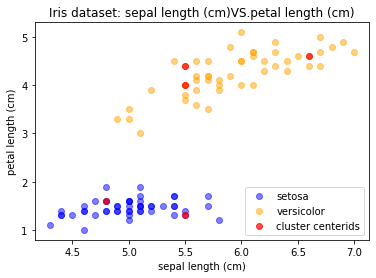

In [7]:
cq.plot_scatter(iris_df,B_df,D1='sepal length (cm)',D2 = 'petal length (cm)')

### Great to see it learns the distribution of our dataset. Now we can construct coreset based on B. For simpility, we decide to construt coreset with size 3 (m = 3).

In [8]:
M = 3

In [9]:
coreset, coreset_weights= cq.BFL16_algorithm(data_vectors, B=B, m=M)
core = []
for c in coreset:
    core.append(c.tolist())
core_df = pd.DataFrame(core[0:M],columns=iris['feature_names'][0:100])
core_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.6,3.0,4.1,1.3
1,5.1,2.5,3.0,1.1
2,5.8,2.7,4.1,1.0


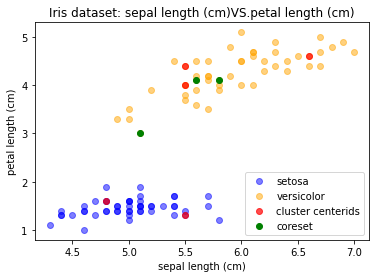

In [10]:
cq.plot_scatter(iris_df,B_df,core_df,D1='sepal length (cm)',D2 = 'petal length (cm)')

### There are two out of three points are used as the member of coreset for orangle cluster and one for blue. Considering that the orangle cluster is sparser, the distribution of coreset is reasonable. Now let's test if the coreset can represent the whole dataset. To do that, 2-Means Clustering will be applied on whole dataset and coreset and compare their cost (sum of squared distance from each point to its closest clusterieds). Cost for different number of elements in coreset will also be plotted.

In [11]:
# We will construct coreset size with 3, 5, 10, and 20. 

# Construct 10 coresets for the same size and select the best one (with lowest cost).
cost_3 = cq.coreset_cost(data_vectors,B,3)
cost_5 = cq.coreset_cost(data_vectors,B,5)
cost_10 = cq.coreset_cost(data_vectors,B,10)
cost_20 = cq.coreset_cost(data_vectors,B,20)

cost_whole = cq.cost_2Means(data_vectors, coreset_vectors=data_vectors)

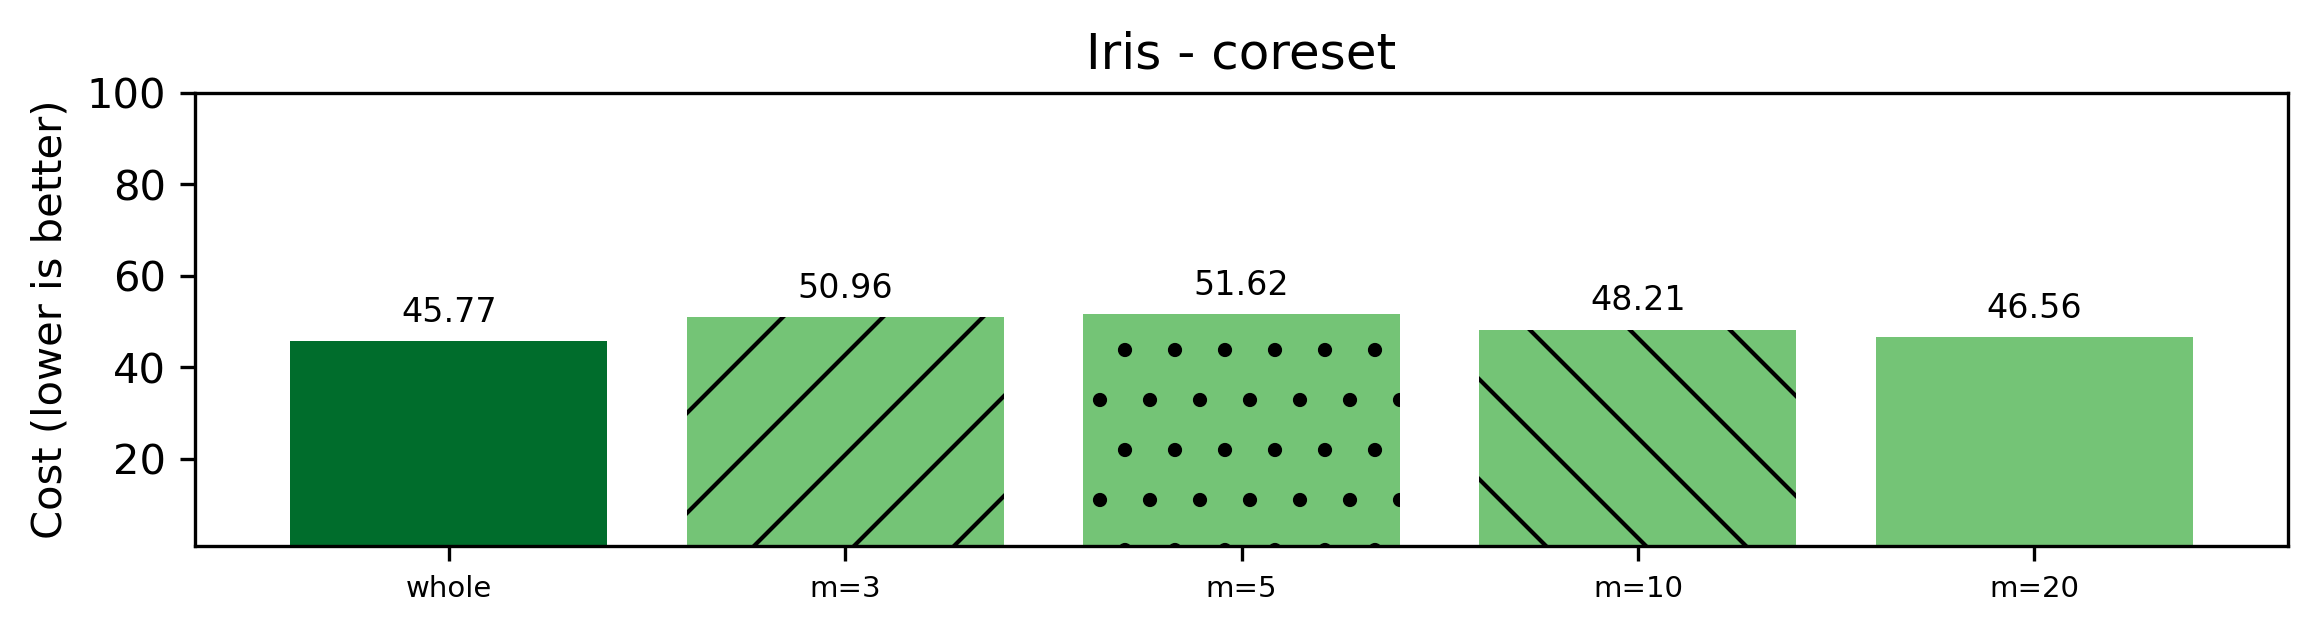

In [12]:
cq.plot_cost(cost_whole,cost_3,cost_5,cost_10,cost_20)

### We can see that cost of using the whole dataset and using different size of coreset to train the 2-Means Clustering is similar (a little bit higher cost is acceptable).

## Another problem has been raised. How do we know which set of points should be taken as a cluster? SOLUTION: QAOA!
## We will run our code in simulator which is noise-free.

In [13]:
provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
shots = 8192
P = 1
qasm_simulator = provider.get_backend('ibmq_qasm_simulator')

/Users/luke/opt/anaconda3/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '
ibmqfactory._initialize_providers:WARNING:2021-12-08 08:24:31,458: Unable to instantiate provider for {'hub': 'ibm-q-melbourne', 'group': 'internal', 'project': 'default'}: string indices must be integers


Fully connected graph:


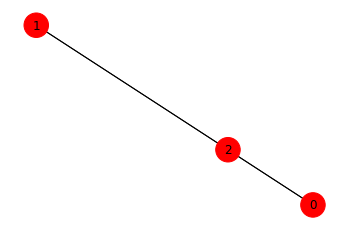

In [14]:
coreset_points, graph, Ham = kq.gen_coreset_graph(metric='dot',load = True)
print('Fully connected graph:')
kq.plot_coreset_graph(coreset_points, graph, twoD=False)

In [15]:
kq.Ham_value(Ham)

The corresponding problem Hamiltonian is:
H = 511802775.7ZZI + 7699359.5ZIZ + 8773443.4IZZ 


In [16]:
counts = kq.qaoa(Ham,P,graph)

        ┌───┐ ░                                                                                    »
   q_0: ┤ H ├─░───■─────────────────────■────■──────────────────────■──────────────────────────────»
        ├───┤ ░ ┌─┴─┐┌───────────────┐┌─┴─┐  │                      │                              »
   q_1: ┤ H ├─░─┤ X ├┤ RZ(3.671e+09) ├┤ X ├──┼──────────────────────┼────■──────────────────────■──»
        ├───┤ ░ └───┘└───────────────┘└───┘┌─┴─┐┌────────────────┐┌─┴─┐┌─┴─┐┌────────────────┐┌─┴─┐»
   q_2: ┤ H ├─░────────────────────────────┤ X ├┤ RZ(5.5225e+07) ├┤ X ├┤ X ├┤ RZ(6.2929e+07) ├┤ X ├»
        └───┘ ░                            └───┘└────────────────┘└───┘└───┘└────────────────┘└───┘»
meas: 3/═══════════════════════════════════════════════════════════════════════════════════════════»
                                                                                                   »
«         ░ ┌────────────┐ ░ ┌─┐      
«   q_0: ─░─┤ RX(10.944) ├─░─┤M├──────
«         ░ ├

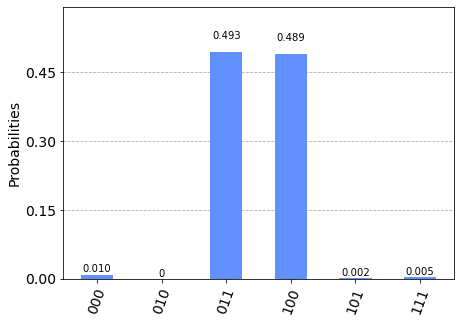

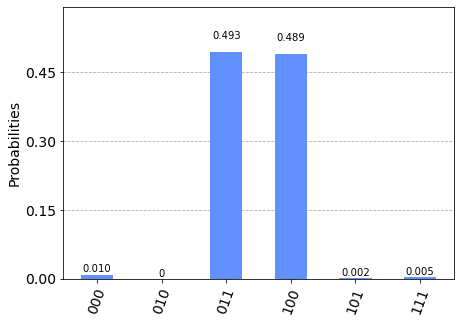

In [17]:
plot_histogram(counts)

### Code above shows the QAOA circuit and measurement result. It tells us that the first and third point should be in one cluster and the second should be in the other cluster. Now we get two clusters - Reached our goal!

In [18]:
#first one is in one cluster and the second two is in the other
order_from_qaoa = [1,0,2] 
cost_after_qaoa = cq.cost_on_classical(coreset_points,order_from_qaoa,data_vectors)

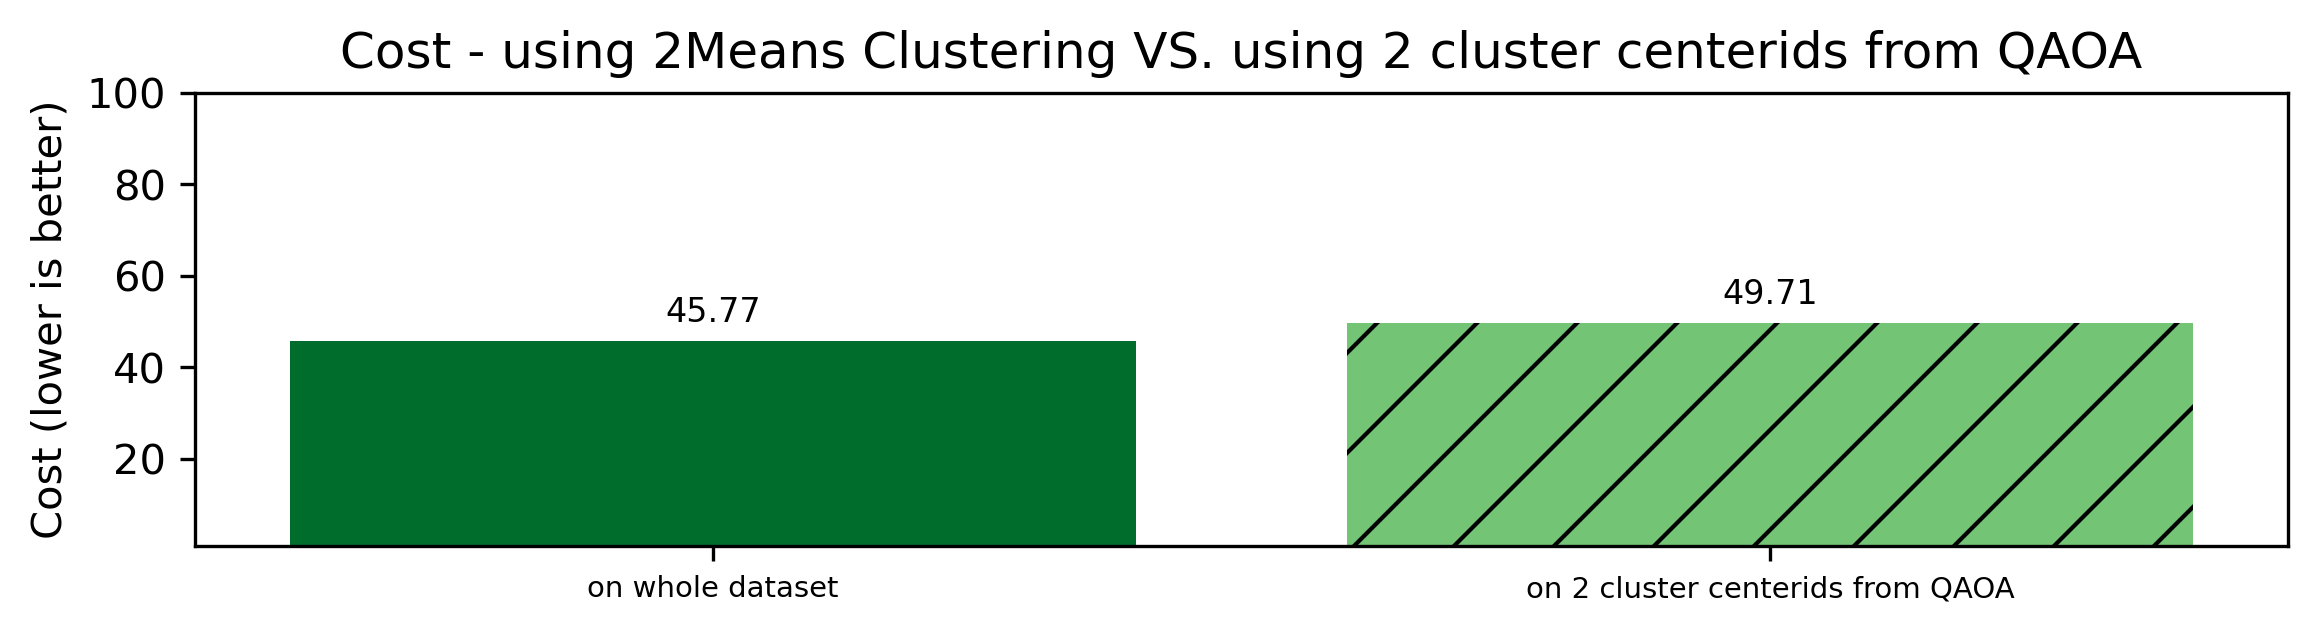

In [19]:
cq.plot_cost_qaoa(cost_whole,cost_after_qaoa)

# We can see that the cost for using 2 cluster centerids constructed from QAOA is  similar with the cost for applying 2Means Clustering on the whole dataset.